<a href="https://colab.research.google.com/github/HYPERNETS/hypernets_training/blob/main/vhroda_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **VHRODA training session: LANDHYPERNET and RADCALNET over Gobabeb**

### **Introduction**

short-url: https://shorturl.at/8HtX1

Within this training session, we will run through processing and comparing a bottom-of-atmosphere (BOA) Landsat-9 (L9) matchup and a top-of-atmosphere (TOA) Sentinel-2 (S2) matchup with both HYPERNETS and RadCalNet (both networks providing data for the same overpass) over the Gobabeb site in Namibia. 
Both these matchups were taken from the list of matchups identified in De Vis et al. (2024; https://doi.org/10.3389/frsen.2024.1323998).

We will assume a starting point where the matchup has already been identified and the files have already been downloaded. Both matchups are in June 2022.
As part of this notebook, we will read in the RadCalNet and HYPERNETS data, mask poor-quality data, and process the data to be comparible with L9 and S2 (e.g. spectral band integration). The bias will be calculated together with their uncertainties and plotted. These uncertainties will come from the product files themselves, and will be propagated throughout the processing chain using the CoMet toolkit. The CoMet toolkit will also be used to handle flags and propagate uncertainties for the HYPERNETS products. We will run through the BOA L9 example in group. Then, users can run through the TOA S2 example individually following the example provided in this notebook. Further matchup can then be processed by the users themselves if time allows. 

We first install the obsarray package (flag handling and accessing uncertainties), the punpy package (uncertainty propagation) and the matheo package (for band integration).

We also import all the relevant python packages we use in this training:

In [1]:
import xarray as xr
import numpy as np
from punpy import MeasurementFunction, MCPropagation
from matheo.band_integration import band_integration
from obsarray.templater.dataset_util import DatasetUtil
import matplotlib.pyplot as plt
import os

Next, we clone the hypernets_training repository, which contains all the datasets used in this training. Some instructions on downloading LANDHYPERNET and RadCalNet data will be provided at the end of this notebook.   

**BOA L9 matchup**

In this section, we will compare some BOA Landsat-9 data to HYPERNETS and RadCalNet. The chosen Landsat-9 product is LC09_L2SP_179076_20220606_20230414_02_T1, which is a tile over Gobabeb from 2022-06-06. Rather than providing the full tile and a reader, we have pre-extracted the region of interest (here taken to be a 200 by 200m box centred on the Gobabeb HYPERNETS and Gobabeb RadCalNet mast, and make this available as a netcdf file on the hypernets_training repository. This data can be read in as:

In [2]:
ds_refl_L9_hyp = xr.load_dataset("example_L9_20220606.nc")     # ROI centred on HYPERNETS
ds_refl_L9_rcn = xr.load_dataset("example_L9_20220606_rcn.nc") # ROI centred on RadCalNet

From these we can determine the reflectance in each band from the mean over the ROI, and its uncertainty (combination of noise and spatial variability) from the standard deviation between pixels:

In [3]:
bands_L9 = ["B1", "B2", "B3", "B4", "B5", "B6"]
wav_L9 = [442.98244284, 482.58889933, 561.33224557, 654.60554515, 864.5708545, 1609.09056245]

refl_L9_hyp = np.array([np.mean(ds_refl_L9_hyp[band].values) for band in bands_L9])
u_refl_L9_hyp = np.array([np.std(ds_refl_L9_hyp[band].values) for band in bands_L9])

refl_L9_rcn = np.array([np.mean(ds_refl_L9_rcn[band].values) for band in bands_L9])
u_refl_L9_rcn = np.array([np.std(ds_refl_L9_rcn[band].values) for band in bands_L9])

Then, we open the HYPERNETS L2A dataset (surface reflectance without site-specific quality checks). These data were downloaded from the LANDHYPERNET data portal (https://landhypernet.org.uk). 

In [4]:
ds_HYP = xr.open_dataset("HYPERNETS_L_GHNA_L2A_REF_20220606T0900_20231226T1435_v2.0.nc")  # read digital effects table

C:\Users\pdv\.conda\envs\hypernets_training\Lib\site-packages\xarray\namedarray\core.py:264: UserWarning: Duplicate dimension names present: dimensions {'wavelength'} appear more than once in dims=('wavelength', 'wavelength'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)


Next, to illustrate the LANDHYPERNET data, we make a spectral plot for a specific viewing geometry (), and a polar polot for a specific wavelength (550nm).

C:\Users\pdv\AppData\Local\Temp\ipykernel_12792\55870767.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  refl_2d[i, ii] = np.abs(refl[id_wav, id_series])


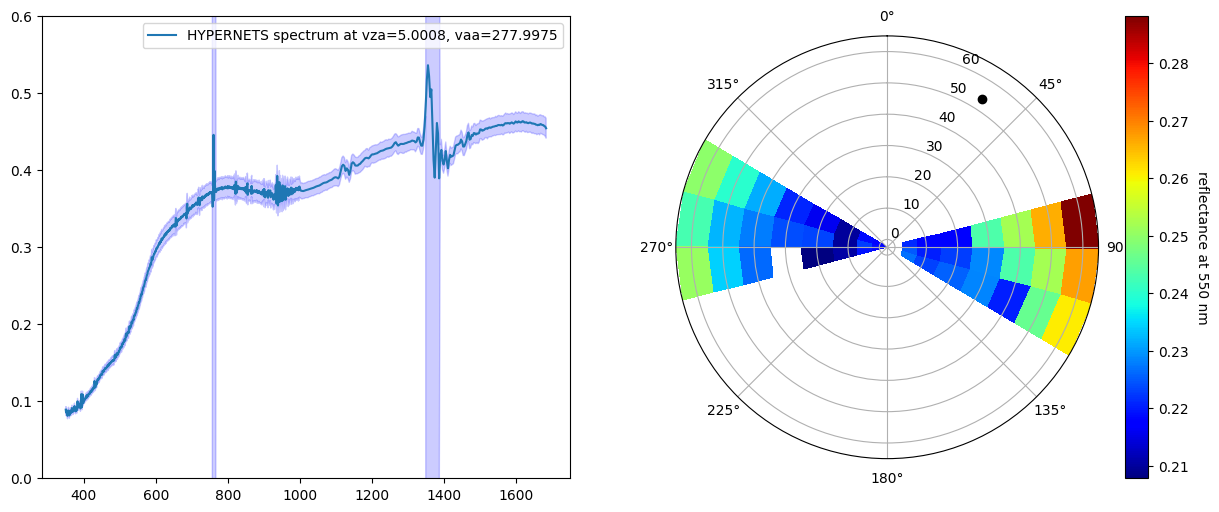

In [5]:
def plot_illustrative_hypernets(dataset, wavelength, series =22):
        # first plot the spectrum for an example geometry:

        fig = plt.figure(figsize=(15,6))
        ax = plt.subplot(121)
        ax.plot(dataset["wavelength"].values, dataset["reflectance"].values[:,series], 
                label = "HYPERNETS spectrum at vza=%s, vaa=%s"%(dataset["viewing_zenith_angle"].values[series],dataset["viewing_azimuth_angle"].values[series]))
        hyp_unc = dataset["reflectance"].values[:,series] /100 * np.sqrt(dataset["u_rel_random_reflectance"].values[:,series]**2+dataset["u_rel_systematic_reflectance"].values[:,series]**2)
        ax.fill_between(
          dataset["wavelength"].values, dataset["reflectance"].values[:,series] - hyp_unc, dataset["reflectance"].values[:,series] + hyp_unc, alpha=0.2, color="b"
        )
        ax.legend()
        ax.set_ylim(0,0.6)


        #next make a polar plot for given wavelength


        saa = np.mean(dataset.solar_azimuth_angle.values % 360)
        sza = np.mean(dataset.solar_zenith_angle.values)
        vaa = dataset.viewing_azimuth_angle.values % 360

        vza = dataset.viewing_zenith_angle.values
        refl = dataset.reflectance.values

        vaa_grid = np.arange(8, 368, 15)
        vza_grid = np.array([0, 5, 10, 20, 30, 40, 50, 60])
        raa_grid = vaa_grid - saa

        id_wav = np.argmin(np.abs(wavelength - dataset.wavelength.values))

        vaa_mesh, vza_mesh = np.meshgrid(np.radians(vaa_grid), vza_grid)

        refl_2d = np.zeros((len(vaa_grid), len(vza_grid)))
        for i in range(len(vaa_grid)):
            for ii in range(len(vza_grid)):
                id_series = np.where(
                    (
                        np.abs(vaa - vaa_grid[i])
                        < 2
                    )
                    & (
                        np.abs(vza - vza_grid[ii])
                        < 2
                    )
                )[0]
                if len(id_series) == 1:
                    refl_2d[i, ii] = np.abs(refl[id_wav, id_series])
                elif len(id_series) > 1:
                    print(
                        "There are multiple series that match the same vaa (%s) and vza (%s) "
                        "within a tolerance of %s and %s degrees respectively."
                        % (
                            vaa_grid[i],
                            vza_grid[ii],
                            2,
                            2,
                        )
                    )
                    refl_2d[i, ii] = np.mean(np.abs(refl[id_wav, id_series]))
        refl_2d[refl_2d == 0] = np.nan
        ax2 = plt.subplot(122, projection='polar')
        ax2.set_theta_direction(-1)
        ax2.set_theta_offset(np.pi / 2.0)
        im = ax2.pcolormesh(
            vaa_mesh,
            vza_mesh,
            refl_2d.T,
            shading="auto",
            cmap=plt.get_cmap("jet"),
        )

        ax2.plot(np.radians(saa), sza, color="k", ls="none", marker="o")

        cbar = fig.colorbar(im)
        cbar.set_label("reflectance at %s nm" % wavelength, rotation=270, labelpad=15)

        plt.show()
        plt.close(fig)

plot_illustrative_hypernets(ds_HYP, 550, series=18)

Have a look at the data available in this dataset. As shown in the dimensions of the dataset, the LANDHYPERNETS products samples at 1551 wavelengths and 44 different geometries. 

In [6]:
ds_HYP

<xarray.Dataset> Size: 21MB
Dimensions:                          (wavelength: 1551, series: 44)
Coordinates:
  * wavelength                       (wavelength) float64 12kB 350.3 ... 1.68...
Dimensions without coordinates: series
Data variables: (12/18)
    bandwidth                        (wavelength) float64 12kB ...
    viewing_azimuth_angle            (series) float64 352B 263.0 278.0 ... 83.0
    pointing_azimuth_angle           (series) float64 352B ...
    viewing_zenith_angle             (series) float64 352B 60.0 60.0 ... 60.0
    solar_azimuth_angle              (series) float64 352B 33.37 33.32 ... 31.72
    solar_zenith_angle               (series) float64 352B 54.1 54.07 ... 53.26
    ...                               ...
    n_valid_scans                    (series) uint8 44B ...
    n_total_scans                    (series) uint8 44B ...
    n_valid_scans_SWIR               (series) uint8 44B ...
    n_total_scans_SWIR               (series) uint8 44B ...
    reflectance                      (wavelength, series) float32 273kB 0.111...
    std_reflectance                  (wavelength, series) float32 273kB ...
Attributes: (12/47)
    type:                             dataset
    abstract:                         The HYPERNETS project (Horizon 2020 res...
    conventions:                      CFv72, NVS2.0
    format_version:                   v2.0
    netcdf_version:                   1.6
    processor_name:                   hypernets_processor
    ...                               ...
    creator_name:                     Pieter De Vis
    creator_email:                    pieter.de.vis@npl.co.uk
    title:                            HYPSTAR Land network dataset of spectra...
    instrument_calibration_file_rad:  HYPERNETS_CAL_HYPSTAR_220261_RAD_v2.0.nc
    instrument_calibration_file_irr:  HYPERNETS_CAL_HYPSTAR_220261_IRR_v2.0.nc
    product_level:                    L_L2A

In the L2A dataset, there is a quality flag variable, which contains quality flags indicating warnings about the data quality. For further information on how to handle these flags, we refer to the following jupyter notebook: https://colab.research.google.com/github/comet-toolkit/comet_training/blob/main/hypernets_surface_reflectance.ipynb . Below, we list the quality flags set in the current dataset (one list for each geometry).

In [7]:
print([DatasetUtil.get_set_flags(flag) for flag in ds_HYP["quality_flag"]])

[['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['outliers', 'series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['outliers', 'series_missing'], ['series_missing'], ['outliers', 'series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['series_missing'], ['outliers', 'series_missing'], ['series_missing']]


The data does have a few warnings (especially the missing series - which indicates at least one geometry from the standard sequence is not present in the data), but none of these are an issue for the current usecase. Some other products do contain more significant quality flags, for which we recommend not using this data for Cal/Val if the flag is raised as highlighted below. We next remove all data that has these "bad" quality flags set. In the near future, when the data is released publicly, the L2B data will be released, which will already have all these data with "bad" quality flags omitted.

In [8]:

bad_flags = [
    "pt_ref_invalid",
    "half_of_scans_masked",
    "not_enough_dark_scans",
    "not_enough_rad_scans",
    "not_enough_irr_scans",
    "no_clear_sky_irradiance",
    "variable_irradiance",
    "half_of_uncertainties_too_big",
    "discontinuity_VNIR_SWIR",
    "single_irradiance_used",
]
flagged = DatasetUtil.get_flags_mask_or(ds_HYP["quality_flag"], bad_flags)
id_series_valid = np.where(~flagged)[0]
ds_HYP = ds_HYP.isel(series=id_series_valid)

We note that for the dataset being used here, this does not remove any data. 
Once we have removed the flagged data, we select the geometry (i.e. series dimension) which most closely matches the satellite viewing angles (which were taken from the satellite data at the region of interest).

In [9]:
vza_L9 = 0.7
#vaa_L9 = 38.1
vzadiff = ds_HYP["viewing_zenith_angle"].values - vza_L9
#vaadiff = np.abs(ds_HYP["viewing_azimuth_angle"].values - vaa_L9 % 360)
angledif_series = np.sqrt(vzadiff**2) # + vaadiff**2)
id_series = np.where(angledif_series < 5)[0]
ds_HYP = ds_HYP.isel(series=id_series)

We do not select on viewing azimuth angle here, as for nadir measurements there is only a single measurement.
We do here give a word of caution around using the LANDHYPERNET nadir measurements as these are prone to shadowing. 
Measurements affected by shadowing will be removed in the L2B files, but are still present in L2A.

The most relevant variables from the xarray dataset are extracted as numpy arrays:

In [10]:
wav_HYP_full = ds_HYP["wavelength"].values
refl_HYP_full = np.mean(ds_HYP["reflectance"].values,axis=1)
u_ran_refl_HYP_full = refl_HYP_full * np.mean(ds_HYP["u_rel_random_reflectance"].values,axis=1) / 100
u_sys_refl_HYP_full = refl_HYP_full * np.mean(ds_HYP["u_rel_systematic_reflectance"].values,axis=1) / 100
u_refl_HYP_full = np.sqrt(u_ran_refl_HYP_full**2+u_sys_refl_HYP_full**2)  # add random and systematic uncertainties for later plotting

The LANDHYPERNET data has a Gaussian spectral response function (SRF) with a width of 3nm for the VNIR sensor (<1000nm) and 10nm for the SWIR sensor (>1000nm). In order to be comparable with the satellite data, we need to spectrally integrate this data to the SRF of the L9 OLI sensor. We here provide a function that performs this band integration using the matheo tool, and returns the first six L9 bands, which we are including in this comparison. 

In [11]:

def band_integrate_L9(reflectance, wavelength):
    """
    Function to perform L9 band integration on reflectance

    :param reflectance: reflectance spectrum
    :param wavelength: wavelengths
    """
    refl_band, band_centres = band_integration.spectral_band_int_sensor(
        d=reflectance,
        wl=wavelength,
        platform_name="Landsat-8",  # the pyspectral library does not contain the L9 SRF, so we use L8 instead which is very similar.
        sensor_name="OLI",
        u_d=None,
    )
    return refl_band[:6]

We use this function to perform the band integration, and also propagate the uncertainties through this process. The punpy tool from the CoMet toolkit is used for the uncertainty propagation. The random and systematic uncertainty are propagated separately, as it is important to correctly take into account the spectral error correlation when propagting these uncertainties.

In [12]:
refl_HYP = band_integrate_L9(refl_HYP_full,wav_HYP_full)

prop = MCPropagation(50, parallel_cores=1)
u_ran_refl_HYP = prop.propagate_standard(band_integrate_L9,[refl_HYP_full,wav_HYP_full],[u_ran_refl_HYP_full,None],["rand",None])
u_sys_refl_HYP = prop.propagate_standard(band_integrate_L9,[refl_HYP_full,wav_HYP_full],[u_sys_refl_HYP_full,None],[ds_HYP["err_corr_systematic_reflectance"].values,None])
u_refl_HYP = np.sqrt(u_ran_refl_HYP**2+u_sys_refl_HYP**2)


C:\Users\pdv\.conda\envs\hypernets_training\Lib\site-packages\matheo\band_integration\band_integration.py:369: UserWarning: The x_r coordinate range (1516.0-1697.0) exceeds the range of the x coordinate range (350.27293897134416-1683.88631738602), and the band integration can thus not be applied.
  warnings.warn(
C:\Users\pdv\.conda\envs\hypernets_training\Lib\site-packages\comet_maths\linear_algebra\matrix_calculation.py:274: UserWarning: One of the correlation matrices is not positive definite. It has been slightly changed (maximum difference of 0.044887128380837416) to accomodate our method.
  warnings.warn(


We note that spectrally, the systematic component is not 100% correlated (but it is fully correlated between repeated measurements/different geometries), but instead an spectral error correlation matrix is provided with the data.

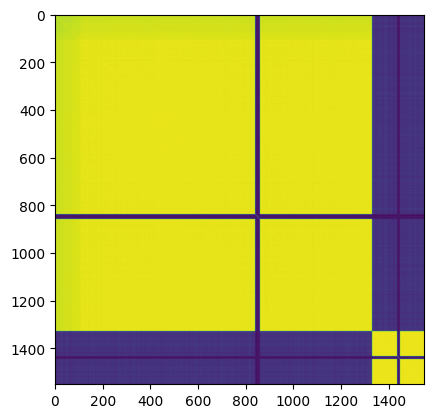

In [13]:
plt.imshow(ds_HYP["err_corr_systematic_reflectance"].values)
plt.show()
plt.close() 

We can compare these band integrated uncertainties to the full resolution uncertainties, and see how they are affected differently by the process. 

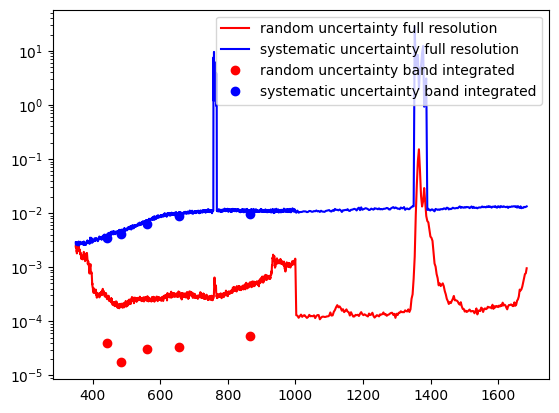

In [14]:
plt.plot(wav_HYP_full,u_ran_refl_HYP_full,"red",label="random uncertainty full resolution")
plt.plot(wav_HYP_full,u_sys_refl_HYP_full,"blue",label="systematic uncertainty full resolution")
#plt.plot(wav_rcn,u_refl_rcn,"green",label="random uncertainty RCN")
plt.plot(wav_L9,u_ran_refl_HYP,"ro",label="random uncertainty band integrated")
plt.plot(wav_L9,u_sys_refl_HYP,"bo",label="systematic uncertainty band integrated")
#plt.plot(wav_L9,u_refl_rcn_band,"go",label="random uncertainty band integrated RCN")
plt.yscale("log") 
plt.legend()
plt.show()
plt.close()  

Next, we read in the RadCalNet data. The BOA data is provided in the .input files that can be downloaded from the RadCalNet portal (https://www.radcalnet.org/). These are ascii files which provide the relevant reflectance and atmospheric data and uncertainties (NetCDF files are also availble). We here extract the reflectance and it's uncertainty for 9:00 UTC (which is column with index 3):

In [15]:

rcn_data = np.genfromtxt("GONA01_2022_157_v00.09.input", dtype="str", delimiter="\t", skip_header=4)
if np.all(rcn_data[:, -1] == ""):
    rcn_data = rcn_data[:, :-1]
wav_rcn = rcn_data[12:223, 0].astype(float)
times_rcn = rcn_data[2, 1:]

refl_rcn = rcn_data[12:223, 3].astype(float)
u_refl_rcn = np.abs(rcn_data[229:440, 3].astype(float))

The RadCalNet data has a triangular SRF with 10nm width. These also have to be band integrated to the L9 OLI SRF.

In [16]:
refl_rcn_band = band_integrate_L9(refl_rcn,wav_rcn)
u_refl_rcn_band = prop.propagate_standard(band_integrate_L9,[refl_rcn,wav_rcn],[u_refl_rcn,None],["rand",None])


**Question 1:** For which of the networks does the uncertainty in the random uncertainty component reduce most by the band integration? (either look at the data, add RadCalNet to the plot showing the HYPERNETS uncertainties, or think about this theoretically.)

The HYPERNETS and RadCalNet data are now at the same spectral scale as the L9 data. All the data is also near simultaneous, in a similar viewing geometry and over a homogeneous surface. So the data is now sufficiently consistent to perform the comparison. We calculate the bias between the satellite and reference as follows, and also calculate the uncertainties:

In [17]:
bias_hyp = ((refl_L9_hyp / refl_HYP) - 1) * 100
u_bias_hyp = np.sqrt((u_refl_L9_hyp / refl_L9_hyp) ** 2 + (u_refl_HYP / refl_HYP) ** 2) * 100

bias_rcn = ((refl_L9_rcn / refl_rcn_band) - 1) * 100
u_bias_rcn = (
    np.sqrt((u_refl_L9_rcn / refl_L9_rcn) ** 2 + (u_refl_rcn_band / refl_rcn_band) ** 2)
    * 100
)

Now, let's plot these biases and uncertainties, as well as the reflectances themselves. We first define a function to make this plot, and then run this for the BOA matchup between Landsat-9 and LANDHYPERNET & RadCalNet on the 6th of June 2022:

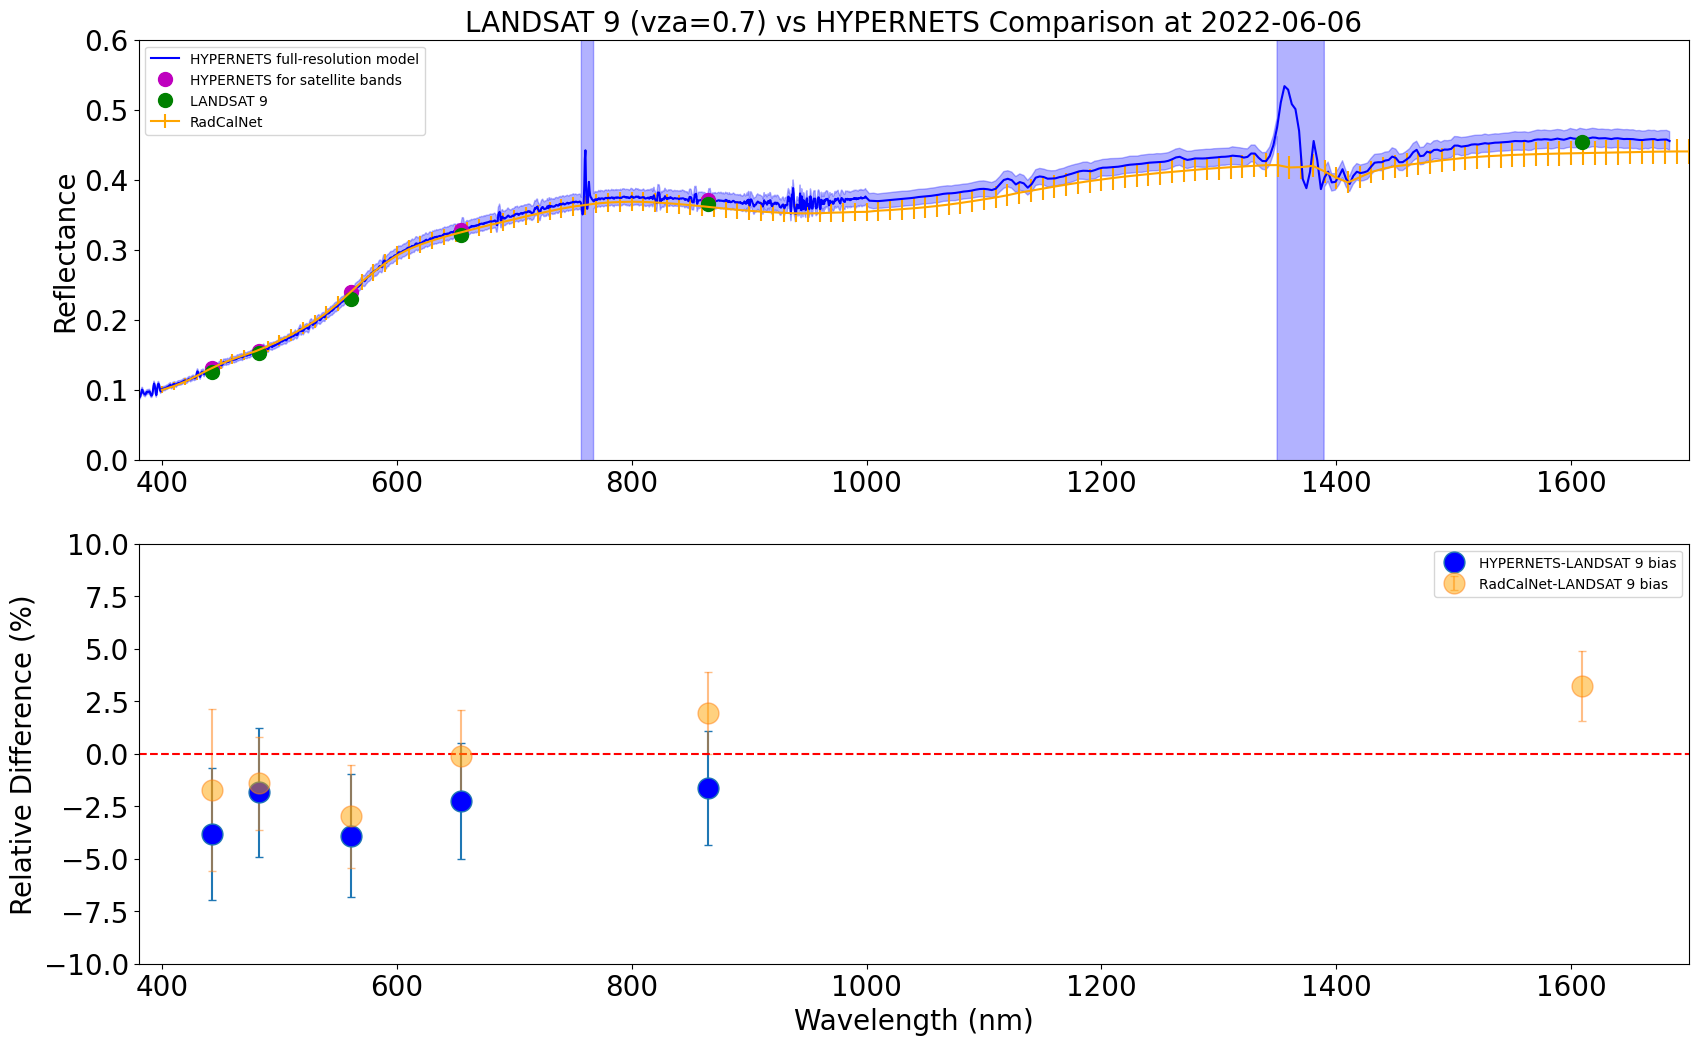

In [18]:
def plot(
    sat: str,
    date: str,
    sat_wav: np.ndarray,
    sat_refl: np.ndarray,
    sat_unc: np.ndarray,
    hyp_wav: np.ndarray,
    hyp_refl: np.ndarray,
    hyp_unc: np.ndarray,
    rcn_wav: np.ndarray,
    rcn_refl: np.ndarray,
    rcn_unc: np.ndarray,
    bias: np.ndarray,
    bias_unc: np.ndarray,
    wavs_band: np.ndarray,
    reflectance_band: np.ndarray,
    reflectance_band_unc: np.ndarray,
    vza: float,
    bias_rcn: np.ndarray,
    bias_rcn_unc: np.ndarray,
):
    """
    Function to plot matchup results
    
    :param sat: satellite name
    :param date: date of matchup
    :param sat_wav: satellite wavelength
    :param sat_refl: satellite reflectance 
    :param sat_unc: satellite reflectance uncertainty
    :param hyp_wav: hypernets (full resolution) wavelength
    :param hyp_refl: hypernets reflectance
    :param hyp_unc: hypernets reflectance uncertainty
    :param rcn_wav: RadCalNet wavelength
    :param rcn_refl: RadCalNet reflectance
    :param rcn_unc:  RadCalNet reflectance uncertainty
    :param bias: hypernets bias (for satellite bands)
    :param bias_unc: hypernets bias uncertainty (for satellite bands)
    :param wavs_band: band-integrated hypernets wavelength
    :param reflectance_band: band-integrated hypernets reflectance
    :param reflectance_band_unc: band-integrated hypernets reflectance uncertainty
    :param vza: satellite viewing zenith angle
    :param bias_rcn: RadCalNet bias (for satellite bands)
    :param bias_rcn_unc: RadCalNet bias uncertainty (for satellite bands)
    :return: 
    """
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 1, 1)
    plt.errorbar(
        wavs_band,
        reflectance_band,
        yerr=reflectance_band_unc,
        fmt="o",
        ls="none",
        ms=10,
        color="m",
        label="HYPERNETS for satellite bands",
    )
    plt.errorbar(
        sat_wav, sat_refl, yerr=sat_unc, fmt="o", ls="none", ms=10, color="g", label=sat
    )
    plt.fill_between(
        hyp_wav, hyp_refl - hyp_unc, hyp_refl + hyp_unc, alpha=0.3, color="b"
    )
    plt.errorbar(rcn_wav, rcn_refl, yerr=rcn_unc, label="RadCalNet", color="orange")
    plt.plot(hyp_wav, hyp_refl, "-b", label="HYPERNETS full-resolution model")
    if sat == "Landsat-8" or sat == "Landsat-9":
        plt.title(
            "Landsat-8/9 (vza=%.1f) vs HYPERNETS TOA Comparison at %s" % (vza, date),
            fontsize=20,
        )
    else:
        plt.title(
            "%s (vza=%.1f) vs HYPERNETS Comparison at %s" % (sat, vza, date),
            fontsize=20,
        )
    plt.ylabel("Reflectance", fontsize=20)
    plt.xlim(380, 1700)
    plt.ylim(0.0, 0.6)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc=2, numpoints=1, scatterpoints=1, facecolor="white")

    plt.subplot(2, 1, 2)
    plt.errorbar(
        sat_wav,
        bias,
        yerr=bias_unc,
        fmt="o",
        mfc="blue",
        ls="none",
        ms=15,
        capsize=3,
        label="HYPERNETS-%s bias" % sat,
    )
    plt.errorbar(
        sat_wav,
        bias_rcn,
        yerr=bias_rcn_unc,
        fmt="o",
        mfc="orange",
        ls="none",
        ms=15,
        capsize=3,
        alpha=0.5,
        label="RadCalNet-%s bias" % sat,
    )
    plt.axhline(y=0, color="r", linestyle="--")
    plt.ylabel("Relative Difference (%)", fontsize=20)
    plt.xlabel("Wavelength (nm)", fontsize=20)
    plt.xlim(380, 1700)
    plt.ylim(-10, 10)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend()
    # plt.legend(loc=2, numpoints=1, scatterpoints=1, facecolor='white')
    plt.show()
    plt.close()

plot("LANDSAT 9", "2022-06-06", wav_L9, refl_L9_hyp, u_refl_L9_hyp, wav_HYP_full, refl_HYP_full, u_refl_HYP_full, wav_rcn,
     refl_rcn, u_refl_rcn, bias_hyp, u_bias_hyp, wav_L9, refl_HYP, u_refl_HYP, vza_L9, bias_rcn, u_bias_rcn)


**Question 2:** Within the shown examples, we have propagated some uncertainty components, but there are many others missing. Could you think of a few uncertainty components that are missing when comparing the in-situ data to satellites?

The results show the biases are within 5% for both RadCalNet and HYPERNETS and thus quite good agreement. 

**TOA matchup**

Next, we perform a comparison for a matchup between Sentinel-2 and HYPERNETS and RadCalNet on the 8th of June 2022. 
This time, the comparison is made at TOA. Specifically, the Sentinel-2 product used is SEQ20220608T090043_vs_S2B_MSIL1C_20220608T084559_N0400_R107_T33KWP_20220608T113756.SAFE. 
We have again extracted a 200 by 200 m region or interest around the HYPERNETS and RadCalNet site, and made it available as a NetCDF file:


In [19]:

ds_refl_S2_hyp = xr.load_dataset("example_S2_20220628.nc")
ds_refl_S2_rcn = xr.load_dataset("example_S2_20220628_rcn.nc")

bands_S2=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B10", "B11", "B8A"]
wav_S2 = [442.69504835,  492.43657768,  559.84905824,  664.62175142,
        704.11493669,  740.49182383,  782.75291928,  832.79041366,
        945.05446558, 1373.46188735, 1613.65941706,  864.71079209]
vza_S2=5.6

refl_S2_hyp = np.array([np.mean(ds_refl_S2_hyp[band].values) for band in bands_S2])
u_refl_S2_hyp = np.array([np.std(ds_refl_S2_hyp[band].values) for band in bands_S2])
refl_S2_rcn = np.array([np.mean(ds_refl_S2_rcn[band].values) for band in bands_S2])
u_refl_S2_rcn = np.array([np.std(ds_refl_S2_rcn[band].values) for band in bands_S2])

HYPERNETS does not (currently) provide TOA reference data. Instead the user would need to propagate the HYPERNETS to TOA themselves using Radiative Transfer (RT) modelling. This was done in De Vis et al (2024a). We here provide the TOA reflectances manually. These were based on propagating the BOA reflectances from the HYPERNETS L2A products to TOA using LibRadtran. Atmospheric properties from the RadCalNet network were used, and uncertainties from both atmospheric properties as well as on the reflectance were also propagated through the RT forward model. For further details we refer to De Vis et al (2024a). We here provide data at full resolution and band integrated (with the S2 SRF) data:

In [20]:
wav_TOA_HYP_full, refl_TOA_HYP_full, u_refl_TOA_HYP_full = np.load("hypernets_TOA_example_20220608_full.npy")
wav_TOA_HYP_band, refl_TOA_HYP_band, u_refl_TOA_HYP_band = np.load("hypernets_TOA_example_20220608_band.npy")

The TOA RadCalNet can be read in the same way as the BOA data. The TOA data is provided in the RadCalNet .output files that can be downloaded from the RadCalNet portal (https://www.radcalnet.org/). We here extract the reflectance and it's uncertainty for 9:00 UTC (which is column with index 3):

In [21]:
rcn_data = np.genfromtxt("GONA01_2022_159_v04.09.output", dtype="str", delimiter="\t", skip_header=4)
if np.all(rcn_data[:, -1] == ""):
    rcn_data = rcn_data[:, :-1]
wav_TOA_rcn = rcn_data[15:226, 0].astype(float)
times_rcn = rcn_data[2, 1:]

refl_TOA_rcn = rcn_data[15:226, 3].astype(float)
u_refl_TOA_rcn = np.abs(rcn_data[232:443, 3].astype(float))

We once more band integrate the RadCalNet data. This time the Sentinel-2 SRF are applied. Band B12 is removed because it is outside the LANDHYPERNET wavelength range.

In [22]:
def band_integrate_S2B(reflectance, wavelength):
    """
    Function to perform L9 band integration on reflectance

    :param reflectance: reflectance spectrum
    :param wavelength: wavelengths
    """
    refl_band, band_centres = band_integration.spectral_band_int_sensor(
        d=reflectance,
        wl=wavelength,
        platform_name="Sentinel-2B",
        sensor_name="MSI",
        u_d=None,
    )
    return np.delete(refl_band, 11)

refl_TOA_rcn_band = band_integrate_S2B(refl_TOA_rcn,wav_TOA_rcn)
u_refl_TOA_rcn_band = prop.propagate_standard(band_integrate_S2B,[refl_TOA_rcn,wav_TOA_rcn],[u_refl_TOA_rcn,None],["rand",None])

We can then again calculate the bias and its uncertainty for both the LANDHYPERNET and RadCalNet data:

In [23]:
bias_TOA_hyp = ((refl_S2_hyp / refl_TOA_HYP_band) - 1) * 100
u_bias_TOA_hyp = (
    np.sqrt((u_refl_S2_hyp / refl_S2_hyp) ** 2 + (u_refl_TOA_HYP_band / refl_TOA_HYP_band) ** 2)
    * 100
)

bias_TOA_rcn = ((refl_S2_rcn / refl_TOA_rcn_band) - 1) * 100
u_bias_TOA_rcn = (
    np.sqrt(
        (u_refl_S2_rcn / refl_S2_rcn) ** 2
        + (u_refl_TOA_rcn_band / refl_TOA_rcn_band) ** 2
    )
    * 100
)

And finally we produce similar plots as for the BOA results:

In [ ]:
plot("Sentinel-2", "2022-06-08", wav_S2, refl_S2_hyp, u_refl_S2_hyp, wav_TOA_HYP_full, refl_TOA_HYP_full, u_refl_TOA_HYP_full, wav_TOA_rcn,
     refl_TOA_rcn, u_refl_TOA_rcn, bias_TOA_hyp, u_bias_TOA_hyp, wav_TOA_HYP_band, refl_TOA_HYP_band, u_refl_TOA_HYP_band, vza_S2, bias_TOA_rcn, u_bias_TOA_rcn)

Similar to above, these demonstrate quite good agreement between the satellite and reference data. For further examples we refer to De Vis et al. (2024, https://doi.org/10.3389/frsen.2024.1323998).

**Question 3:** Why is B10 (at 1375 nm) not visible in the bias plot?

**Question 4:** We have not corrected for the 15 min time difference between the Sentinel-2 and network observation. Will this make much of a difference, and if so why?

**Choose a matchup yourself**

There is a more simple and a more advanved option for the next exercise.

- more advanced (probably not enough time during this limited time-slot, but feel free to start exploring and continue afterwards): Perform a comparison for an overpass over Gobabeb by one of your own satellites. Download RadCalNet or LANDHYPERNET data from the respective data portals (or if you don't have a login, ask someone within the training team to make some specific data available within the hypernets_training repository). 

- Or alternatively, choose one (or more/all) of the following BOA L9 files over Gobabeb during October 2024 (all available for use within the hypernets_training repository that was previously cloned) and perform a comparison with the provided LANDHYPERNET and RadCalNet files:


In [ ]:
L9_hypernets_paths = ['example_L9_20241025.nc', 'example_L9_20241017.nc', 'example_L9_20241009.nc', 'example_L9_20241001.nc']

hypernet_paths = ['HYPERNETS_L_GHNA_L2A_REF_20241025T0900_20241114T0243_v2.1.nc', 'HYPERNETS_L_GHNA_L2A_REF_20241017T0900_20241114T0343_v2.1.nc', 'HYPERNETS_L_GHNA_L2A_REF_20241009T0901_20241016T1731_v2.1.nc', 'HYPERNETS_L_GHNA_L2A_REF_20241001T0900_20241001T1525_v2.1.nc']



L9_rcn_paths = ['example_L9_20241025_rcn.nc', 'example_L9_20241017_rcn.nc', 'example_L9_20241009_rcn.nc', 'example_L9_20241001_rcn.nc']

rcn_paths = ['GONA01_2024_299_v00.09.input','GONA01_2024_291_v00.09.input','GONA01_2024_283_v00.09.input','GONA01_2024_275_v00.09.input']


We note that the nadir measurements from the HYPERNETS sequences at this time of year and this time of day are affected by shadows. 
We thus recommend to instead use a viewing zenith angle of 5 or 10 degrees (averaging over different azimuths). 
In the L2B files, measurements affected by shadows will be removed. In the future, HYPERNETS products might be produced where the measurements affected by shadows are replaced by interpolated values (using BRDF model).

**Question 5:** Did you manage to generate more matchups?
- No, not enough time
- No, I wasn't sure how to do it
- Yes, a single one
- Yes, multiple
- Yes, I used my own satellite data. 

Here is the link for the wooclap quiz: https://app.wooclap.com/VHRODA2?from=banner